# **Detailed Analysis**

( The description of figure will change- it is just an sample to mention the concepts)

- Best Configuration
- Best Configuration: 30 years, batch size 32, epochs 80
- MAE: 3.2587


- Training Loss: 2.3098
- Validation Loss: 34.2010

**Observations and Implications**

- **Training Loss:**

Lowest Training Loss: Generally observed with configurations involving 30 years of data and higher epochs (e.g., epochs 60 or 80).
Trends: Training loss decreases as the number of epochs increases, which indicates that the model is fitting the training data better with more training time. However, very high training loss values in configurations with fewer epochs or different batch sizes suggest that the model may not have enough time or capacity to learn effectively.
Validation Loss:

- **Lowest Validation Loss:**

Achieved with the configuration of 30 years, batch size 32, and 80 epochs, which is the same as the configuration with the best MAE.

- **Trends:** Validation loss also tends to decrease with more epochs up to a point, showing that the model generalizes better with more training. However, the validation loss does not decrease as much in some cases where the training loss is very low. This could suggest overfitting, where the model performs well on training data but less well on unseen data.

- **Comparison of Training Loss and Validation Loss:**

- **Overfitting:** When training loss is significantly lower than validation loss, it often indicates overfitting. The model learns to perform well on the training data but struggles with new, unseen data. For example, in the configuration with 30 years of data and a batch size of 64, the training loss is quite low, but the validation loss is relatively higher, suggesting overfitting.

- **Generalization:** The best configuration (30 years, batch size 32, epochs 80) shows relatively balanced training and validation losses, indicating good generalization. The validation loss is higher than the training loss but not excessively so, which is a positive sign.

**Summary**


- **Best Overall Performance:**

- The configuration with 30 years of data, batch size 32, and 80 epochs is the best based on MAE, training loss, and validation loss. This setup provides a good balance between fitting the training data and generalizing to unseen data.
Training vs. Validation Loss:

- A lower training loss compared to validation loss suggests that while the model fits the training data well, there might be some overfitting. The goal is to minimize both losses and ensure that they are as close as possible, which indicates the model's ability to generalize.
Practical Recommendations:

- Monitor Overfitting: Keep an eye on the gap between training and validation loss. Consider regularization techniques or early stopping to mitigate overfitting if necessary.

- Continue Experimenting: Further experiment with different configurations or techniques (e.g., more data, different architectures) if we aim to improve performance even more.


- By considering both training and validation losses along with MAE, we can get a more comprehensive understanding of our model’s performance and make more informed decisions about adjustments and improvements.

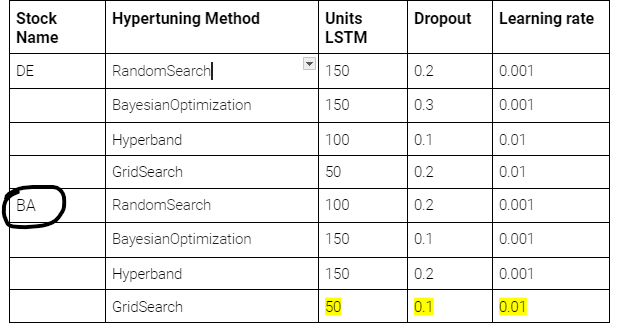

We included a parameter to check for overfitting in the code by monitoring the training and validation losses during the model training process. Overfitting occurs when the model performs well on the training data but poorly on the validation data, indicating that it has learned the training data too well (including noise) and is not generalizing to unseen data.

Steps :

- Split the Training Data: Split the training data into training and validation sets.
- Track Training and Validation Losses: Use these sets to track the training and validation losses during the model fitting.
- Early Stopping (Optional): Not implemented as it is not required and can alter the actual results by stopping early.

## Random Search

In [2]:
# Include overfitting parameter
# No EARLY STOP


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (Random Search - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}



# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss

# Possible values for epochs and batch size
batch_sizes = [32, 64]
# batch_sizes = [32, 64, 128, 256]
# epochs_list = [20, 40, 50, 75]
epochs_list = [20, 40, 60, 80]






# Varying training periods
#training_years = [50, 40, 30, 20, 10]

training_years = [10,5, 4, 3, 2]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    print(train_start, train_end)
    df_train = df[train_start:train_end]


    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed
c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2013-12-31 00:00:00 2023-12-31 00:00:00
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
Training with 10 years, batch_size 32, epochs 20 - MAE: 192.394287593781
Training Loss: 31.51569175720215, Validation Loss: 96.3690414428711


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000245907AE200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
Training with 10 years, batch_size 32, epochs 40 - MAE: 107.33541385711186
Training Loss: 17.6962833404541, Validation Loss: 22.272245407104492


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Training with 10 years, batch_size 32, epochs 60 - MAE: 64.98738073924231
Training Loss: 14.36559772491455, Validation Loss: 10.626631736755371


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Training with 10 years, batch_size 32, epochs 80 - MAE: 101.51932731507317
Training Loss: 17.943635940551758, Validation Loss: 24.838544845581055


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
Training with 10 years, batch_size 64, epochs 20 - MAE: 280.3934563530816
Training Loss: 58.21025466918945, Validation Loss: 184.34768676757812


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step
Training with 10 years, batch_size 64, epochs 40 - MAE: 179.40327768477184
Training Loss: 27.3634033203125, Validation Loss: 83.76808166503906


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Training with 10 years, batch_size 64, epochs 60 - MAE: 101.13258046952505
Training Loss: 16.084455490112305, Validation Loss: 18.695220947265625


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Training with 10 years, batch_size 64, epochs 80 - MAE: 128.38003491598462
Training Loss: 19.530067443847656, Validation Loss: 36.93461608886719
2018-12-31 00:00:00 2023-12-31 00:00:00


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
Training with 5 years, batch_size 32, epochs 20 - MAE: 308.3513491191561
Training Loss: 190.09178161621094, Validation Loss: 241.21751403808594


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Training with 5 years, batch_size 32, epochs 40 - MAE: 211.50962853810145
Training Loss: 94.5794448852539, Validation Loss: 144.37579345703125


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Training with 5 years, batch_size 32, epochs 60 - MAE: 131.22578454396083
Training Loss: 56.26032257080078, Validation Loss: 64.09195709228516


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Training with 5 years, batch_size 32, epochs 80 - MAE: 123.92933679005456
Training Loss: 55.576290130615234, Validation Loss: 56.795509338378906


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Training with 5 years, batch_size 64, epochs 20 - MAE: 382.3694307841952
Training Loss: 260.865234375, Validation Loss: 315.235595703125


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Training with 5 years, batch_size 64, epochs 40 - MAE: 308.8957827129061
Training Loss: 187.96987915039062, Validation Loss: 241.76193237304688


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Training with 5 years, batch_size 64, epochs 60 - MAE: 225.5295870341952
Training Loss: 106.88008880615234, Validation Loss: 158.395751953125


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Training with 5 years, batch_size 64, epochs 80 - MAE: 259.0409395732577
Training Loss: 136.91314697265625, Validation Loss: 191.9071044921875
2019-12-31 00:00:00 2023-12-31 00:00:00


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
Training with 4 years, batch_size 32, epochs 20 - MAE: 359.8009264506991
Training Loss: 269.8829345703125, Validation Loss: 294.47021484375


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Training with 4 years, batch_size 32, epochs 40 - MAE: 280.106201414078
Training Loss: 189.90036010742188, Validation Loss: 214.7755126953125


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training with 4 years, batch_size 32, epochs 60 - MAE: 167.6841280498202
Training Loss: 77.66609191894531, Validation Loss: 102.35344696044922


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Training with 4 years, batch_size 32, epochs 80 - MAE: 111.77928185841394
Training Loss: 42.28107452392578, Validation Loss: 46.492698669433594


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Training with 4 years, batch_size 64, epochs 20 - MAE: 397.25619531056236
Training Loss: 306.4676208496094, Validation Loss: 331.925537109375


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Training with 4 years, batch_size 64, epochs 40 - MAE: 349.0968554057772
Training Loss: 257.6922912597656, Validation Loss: 283.7661437988281


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Training with 4 years, batch_size 64, epochs 60 - MAE: 304.1797945537264
Training Loss: 212.88909912109375, Validation Loss: 238.84910583496094


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
Training with 4 years, batch_size 64, epochs 80 - MAE: 261.93209863087486
Training Loss: 170.51446533203125, Validation Loss: 196.60142517089844
2020-12-31 00:00:00 2023-12-31 00:00:00


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Training with 3 years, batch_size 32, epochs 20 - MAE: 400.25793862721275
Training Loss: 322.6799621582031, Validation Loss: 339.7524108886719


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Training with 3 years, batch_size 32, epochs 40 - MAE: 349.7636797465975
Training Loss: 271.7965393066406, Validation Loss: 289.2581787109375


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Training with 3 years, batch_size 32, epochs 60 - MAE: 332.0692675151522
Training Loss: 253.54100036621094, Validation Loss: 271.5637512207031


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Training with 3 years, batch_size 32, epochs 80 - MAE: 168.1370089091952
Training Loss: 91.55248260498047, Validation Loss: 107.6314926147461


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
Training with 3 years, batch_size 64, epochs 20 - MAE: 432.7292902507479
Training Loss: 354.2818908691406, Validation Loss: 372.2237548828125


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Training with 3 years, batch_size 64, epochs 40 - MAE: 394.30916619679283
Training Loss: 315.9852600097656, Validation Loss: 333.80364990234375


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Training with 3 years, batch_size 64, epochs 60 - MAE: 300.0781099834139
Training Loss: 221.95773315429688, Validation Loss: 239.5725860595703


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
Training with 3 years, batch_size 64, epochs 80 - MAE: 320.6231997050936
Training Loss: 243.15121459960938, Validation Loss: 260.11767578125
2021-12-31 00:00:00 2023-12-31 00:00:00


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Training with 2 years, batch_size 32, epochs 20 - MAE: 416.9601824321444
Training Loss: 312.39013671875, Validation Loss: 396.70947265625


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training with 2 years, batch_size 32, epochs 40 - MAE: 398.51968026539635
Training Loss: 294.34954833984375, Validation Loss: 378.2689514160156


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Training with 2 years, batch_size 32, epochs 60 - MAE: 367.2123339214022
Training Loss: 262.9949645996094, Validation Loss: 346.96160888671875


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Training with 2 years, batch_size 32, epochs 80 - MAE: 365.6116259135897
Training Loss: 260.49224853515625, Validation Loss: 345.36090087890625


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Training with 2 years, batch_size 64, epochs 20 - MAE: 431.83759713551353
Training Loss: 326.8190002441406, Validation Loss: 411.5869140625


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Training with 2 years, batch_size 64, epochs 40 - MAE: 420.5728189983065
Training Loss: 315.67864990234375, Validation Loss: 400.3221130371094


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Training with 2 years, batch_size 64, epochs 60 - MAE: 407.3540804423983
Training Loss: 302.1891174316406, Validation Loss: 387.1033630371094


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Training with 2 years, batch_size 64, epochs 80 - MAE: 387.1645052470858
Training Loss: 281.7808532714844, Validation Loss: 366.9137878417969
Best Configuration - Years: 10, Batch Size: 32, Epochs: 60 - MAE: 64.98738073924231


In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
# Best Configuration - Years: 10, Batch Size: 32, Epochs: 60 - MAE: 3.2200385199652777


best_years = 5
best_batch_size = 32
best_epochs = 60

##########################################################################
# Configuration for the LSTM model (Random Search - ******IMPORTANT******)
##########################################################################
config = {'units': 100, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '2021-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

#test_start = '2024-01-01'
#test_end = '2024-08-10'

test_start = '2023-01-01'
test_end = '2024-08-10'
# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    
    # First LSTM layer with return_sequences=True
    model.add(LSTM(units=units, return_sequences=True, input_shape=(90, 1)))
    model.add(Dropout(dropout))  # Dropout for regularization
    
    # Second LSTM layer
    model.add(LSTM(units=units // 2, return_sequences=True))  # Smaller number of units
    model.add(Dropout(dropout))  # Dropout for regularization
    
    # Third LSTM layer, with return_sequences=False, indicating end of LSTM stack
    model.add(LSTM(units=units // 2, return_sequences=False))
    model.add(Dropout(dropout))  # Dropout for regularization
    
    # Final Dense layer
    model.add(Dense(1))
    
    # Compile the model with Adam optimizer and MAE loss
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions




# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31').tz_localize(None)
print(train_end)
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 60
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed
c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2023-12-31 00:00:00
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
MAE on Test Data: 295.3771754451118


[*********************100%%**********************]  1 of 1 completed
c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 30.3203 - val_loss: 80.8149
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 22.6194 - val_loss: 77.6355
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 19.3572 - val_loss: 74.6628
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 16.8786 - val_loss: 71.8293
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - loss: 14.6127 - val_loss: 69.3330
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 11.8343 - val_loss: 67.2530
Epoch 7/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 11.2504 - val_loss: 65.7983
Epoch 8/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - loss: 10.3389 - val_loss: 64.5933
Epoch 9/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 10.2416 - val_loss: 63.6177
Epoch 10/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 10.0987 - val_loss: 62.7460
Epoch 11/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - loss: 9.3605 - val_loss: 62.0334
Epoch 12/60
37/37 ━━━━━━━━━━━

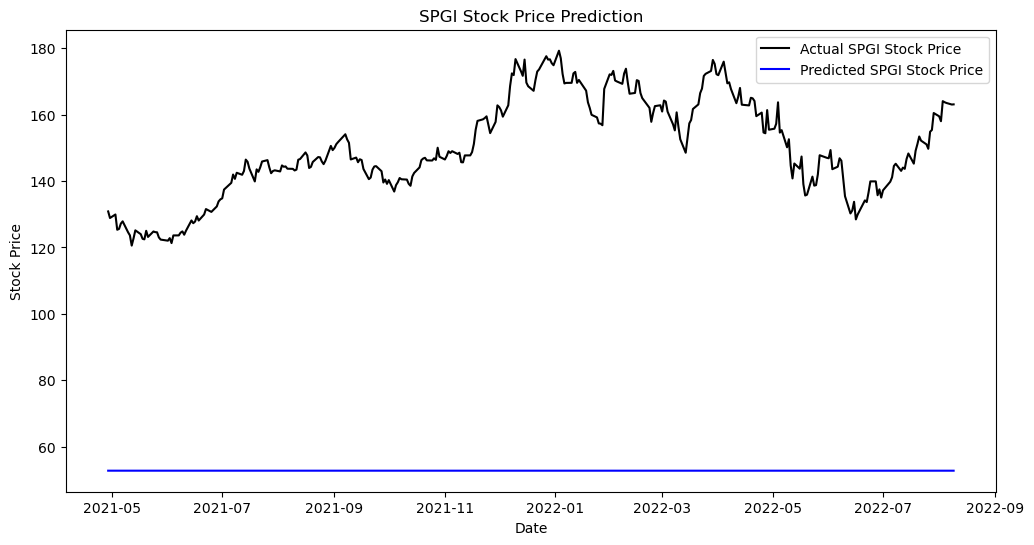

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Define the stock symbol and date range
stock_symbol = 'BA'
start_date = '2015-01-01'
end_date = '2022-08-10'

# Download data
df = yf.download(stock_symbol, start=start_date, end=end_date)['Adj Close']

# Convert to DataFrame
df = df.reset_index()
df.columns = ['Date', 'Close']

# Prepare the data for LSTM
window_size = 60  # Number of days to look back for each prediction

def preprocess_data(df, window_size):
    data = df['Close'].values.reshape(-1, 1)  # Use 'Close' prices
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]
    return X, y

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

X_train, y_train = preprocess_data(train_df, window_size)
X_test, y_test = preprocess_data(test_df, window_size)


def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units // 2, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Model configuration
units = 150
dropout = 0.2
learning_rate = 0.001

model = create_lstm_model(units, dropout, learning_rate)


# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
epochs = 60
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])


# Predict using the model
predictions = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'][window_size:], y_test, color='black', label='Actual SPGI Stock Price')
plt.plot(test_df['Date'][window_size:], predictions, color='blue', label='Predicted SPGI Stock Price')
plt.title('SPGI Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

Epoch 1/60



c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 142.0777 - val_loss: 289.5653
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 132.4132 - val_loss: 286.2053
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 129.2425 - val_loss: 283.1301
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 127.4844 - val_loss: 280.1520
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - loss: 122.0190 - val_loss: 277.2214
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 122.9673 - val_loss: 274.3118
Epoch 7/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - loss: 115.8631 - val_loss: 271.4189
Epoch 8/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 113.7888 - val_loss: 268.5453
Epoch 9/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 111.1500 - val_loss: 265.6813
Epoch 10/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 109.3861 - val_loss: 262.8291
Epoch 11/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 105.2265 - val_loss: 259.9839
Epoch 12/60
37/37 

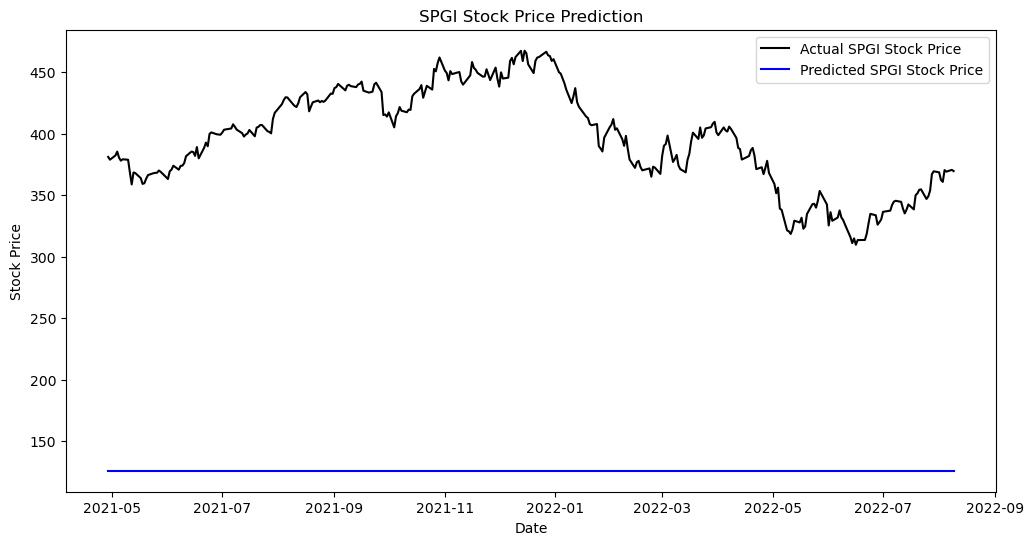

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Define the stock symbol and date range
stock_symbol = 'SPGI'
start_date = '2015-01-01'
end_date = '2022-08-10'

# Download data
df = yf.download(stock_symbol, start=start_date, end=end_date)['Adj Close']

# Convert to DataFrame
df = df.reset_index()
df.columns = ['Date', 'Close']

# Prepare the data for LSTM
window_size = 60  # Number of days to look back for each prediction

def preprocess_data(df, window_size):
    data = df['Close'].values.reshape(-1, 1)  # Use 'Close' prices
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]
    return X, y

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

X_train, y_train = preprocess_data(train_df, window_size)
X_test, y_test = preprocess_data(test_df, window_size)


def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units // 2, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Model configuration
units = 150
dropout = 0.2
learning_rate = 0.001

model = create_lstm_model(units, dropout, learning_rate)


# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
epochs = 60
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])


# Predict using the model
predictions = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'][window_size:], y_test, color='black', label='Actual SPGI Stock Price')
plt.plot(test_df['Date'][window_size:], predictions, color='blue', label='Predicted SPGI Stock Price')
plt.title('SPGI Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Bayesian Optimization



In [ ]:
# Include overfitting parameter



import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (Bayesian  - ******IMPORTANT******)
##########################################################################
config = {'units': 100, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss



# Possible values for epochs and batch size
batch_sizes = [32, 64]
epochs_list = [20, 40, 60, 80]





# Varying training periods
# Ex- If we are using a 20-year training period, we will use data from 20 years before
# the end date of your training set. The end date of the training data is fixed at 2023-12-31,
# and the start date is calculated by subtracting 20 years from this end date.

training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 4ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 389.41772909013054
Training Loss: 0.6419885754585266, Validation Loss: 164.61538696289062
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 395.74134947761655
Training Loss: 0.6116853952407837, Validation Loss: 168.5093994140625
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 406.5645722888765
Training Loss: 1.0126392841339111, Validation Loss: 181.79661560058594
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 403.0495383853004
Training Loss: 0.8981713056564331, Validation Loss: 174.24710083007812
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 397.14037649972096
Training Loss: 0.6059040427207947, Validation Loss: 168.76734924316406
2/2 [=============

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go


# Best Configuration - Years: 10, Batch Size: 64, Epochs: 80 - MAE: 3.0124608599950395


##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
best_years = 10
best_batch_size = 32
best_epochs = 80

##########################################################################
# Configuration for the LSTM model (Bayesian  - ******IMPORTANT******)
##########################################################################
config = {'units': 100, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions




# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 5ms/step
MAE on Test Data: 32.88434467618428


## Hyperband

In [ ]:
# Include overfitting parameter
# No EARLY STOP


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (Hyperband  - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss



# Possible values for epochs and batch size
batch_sizes = [32, 64]
epochs_list = [20, 40, 60, 80]






# Varying training periods
# Ex- If we are using a 20-year training period, we will use data from 20 years before
# the end date of your training set. The end date of the training data is fixed at 2023-12-31,
# and the start date is calculated by subtracting 20 years from this end date.

training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 392.84876275441
Training Loss: 0.7680743932723999, Validation Loss: 166.9007110595703
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 389.20641351124596
Training Loss: 0.7507827877998352, Validation Loss: 163.732666015625
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 399.5402729700482
Training Loss: 1.1837022304534912, Validation Loss: 173.43560791015625
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 390.98035903204055
Training Loss: 1.10163414478302, Validation Loss: 167.59112548828125
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 387.4120001414465
Training Loss: 0.6315317153930664, Validation Loss: 161.4898681640625
2/2 [=====================

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Best Configuration - Years: 30, Batch Size: 32, Epochs: 60 - MAE: 3.071416219075521


##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
best_years = 10
best_batch_size = 32
best_epochs = 80

##########################################################################
# Configuration for the LSTM model (Hyperband  - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions




# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 5ms/step
MAE on Test Data: 30.58630855499752


## Grid Search

In [ ]:
# Include overfitting parameter
# No EARLY STOP


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (GRID Search  - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss



# Possible values for epochs and batch size
batch_sizes = [32, 64]
epochs_list = [20, 40, 60, 80]





# Varying training periods
# Ex- If we are using a 20-year training period, we will use data from 20 years before
# the end date of your training set. The end date of the training data is fixed at 2023-12-31,
# and the start date is calculated by subtracting 20 years from this end date.

training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 392.4785319131518
Training Loss: 0.6561456322669983, Validation Loss: 165.26991271972656
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 404.26564013768757
Training Loss: 0.7176506519317627, Validation Loss: 177.24729919433594
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 407.340687464154
Training Loss: 2.5182924270629883, Validation Loss: 181.76708984375
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 393.2445261516268
Training Loss: 0.6779260039329529, Validation Loss: 165.013427734375
2/2 [==============================] - 0s 5ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 396.0409002758208
Training Loss: 0.5992680191993713, Validation Loss: 167.1132354736328
2/2 [=====================

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Best Configuration - Years: 20, Batch Size: 64, Epochs: 40 - MAE: 3.7216394818018355


##################################
# Define the best configuration
#################################
# IMPORTANT
#################################

best_years = 10
best_batch_size = 32
best_epochs = 20

##########################################################################
# Configuration for the LSTM model (GRID Search  - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['SPGI']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions



# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 5ms/step
MAE on Test Data: 280.65760003952755


In [ ]:
"""

import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

!pip install tensorflow-gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

"""


'\n\nimport numpy as np\nimport pandas as pd\nimport yfinance as yf\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom sklearn.metrics import mean_absolute_error\nfrom sklearn.preprocessing import MinMaxScaler\nimport plotly.graph_objects as go\n\n!pip install tensorflow-gpu\nprint("Num GPUs Available: ", len(tf.config.list_physical_devices(\'GPU\')))\n\n'